# Introduction to Gravity and Magnetic Field Classes

*pyshtools* has dedicated classes for working with gravitational and magnetic field data. These classes extend the functionality of the classes `SHCoeffs` and `SHGrid` by adding several standard operations related to potential fields. Specific operations include the computation of the geoid, the computation of the three vector components of the gravitational and magnetic fields, the computation of the gravity and magnetic field tensor and eigenvalues, and the computation of the gravitational potential from relief along an interface.

To start using the gravity and magnetic field classes, first import the standard *matplotlib* package, the *pyshtools* package, and the *pyshtools* subpackage *constant*:

In [1]:
import matplotlib.pyplot as plt
import pyshtools as pysh
from pyshtools import constant

In [2]:
pysh.utils.figstyle(rel_width=0.75)
%config InlineBackend.figure_format = 'retina'  # if you are not using a retina display, comment this line

## Gravity Field Classes

Operations on gravity fields are performed using the classes `SHGravCoeffs`, `SHGravGrid`, `SHGravTensor`, and `SHGeoid`. In gereral, the coefficients are stored in an `SHGravCoeffs` class instance, and this instance is used to initialize the other classes with global grids.

There are several ways to initialize an `SHGravCoeffs` class instance:
* `SHGravCoeffs.from_zeros()` - Set the degree 0 term to 1 and all other coefficients to zero.
* `SHGravCoeffs.from_array()` - Import a *numpy* array of spherical harmonic coefficients.
* `SHGravCoeffs.from_file()` - Read coefficients from a file.
* `SHGravCoeffs.from_random()` - Initialize the coefficients as random variables with a given power spectrum.
* `SHGravCoeffs.from_shape()` - Compute the gravitational potential coefficients from relief along an interface.

Unlike `SHCoeffs`, when initializing an `SHGravCoeffs` class instance, it is necessary to specify the attributes `gm`, `r0`, and optionally `omega`, for the GM, reference radius of the coefficients, and the angular rotation rate of the body. 

We start by reading the gravitational potential coefficients and errors for the planet Mars. We make use of the model GMM-3 of Genova et al. (2016), where `r0` and `gm` are set by the first two elements of the file's header line. If the file didn't contain a header with this information, these parameters could be specified explicitly by using the keywords `gm` and `r0`. We note that the header line of this file uses units of kilometers instead of meters, so we convert the values in the header to meters by specifiying `header_units='km'`:

In [3]:
clm = pysh.SHGravCoeffs.from_file('../ExampleDataFiles/gmm3_120_sha.tab',
                                  errors=True,
                                  header_units='km')

We can inspect this class instance by using the `info()` method, by `print(clm)`, or simply by entering the name of the class instance at the prompt:

In [4]:
clm.info()

kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 120
GM (m3 / s2) = 42828372854187.75
r0 (m) = 3396000.0
Omega (rad / s) = None
errors are set: True
header = ['3.3960000000000000E+03', '0.4282837285418775E+05', '0.2380000000000000E+04', '120', '120', '1', '0.0000000000000000E+00', '0.0000000000000000E+00']


Using the `constant` submodule, we set the angular rotation rate of the planet, which is necessary when calculating the normal gravity and geoid. We also define variables for the planet's reference ellipsoid, such as the semimajor axis `a`, the flattening `f`, and the reference potential `u0`:

In [5]:
clm.set_omega(constant.omega_mars.value)

a = constant.a_mars.value
f = constant.f_mars.value
u0 = constant.u0_mars.value

The spectrum of the function can be plotted using the methods `plot_spectrum()` and `plot_spectrum2d()`. Unlike `SHCoeffs` class instances, we have the option of plotting the power spectrum of the geoid (default), potential, radial gravity, or total gravitational field as specified by the optional parameter `function`. The total spectrum is analogous to the Lowes-Mauersberger spectrum of magnetic fields.

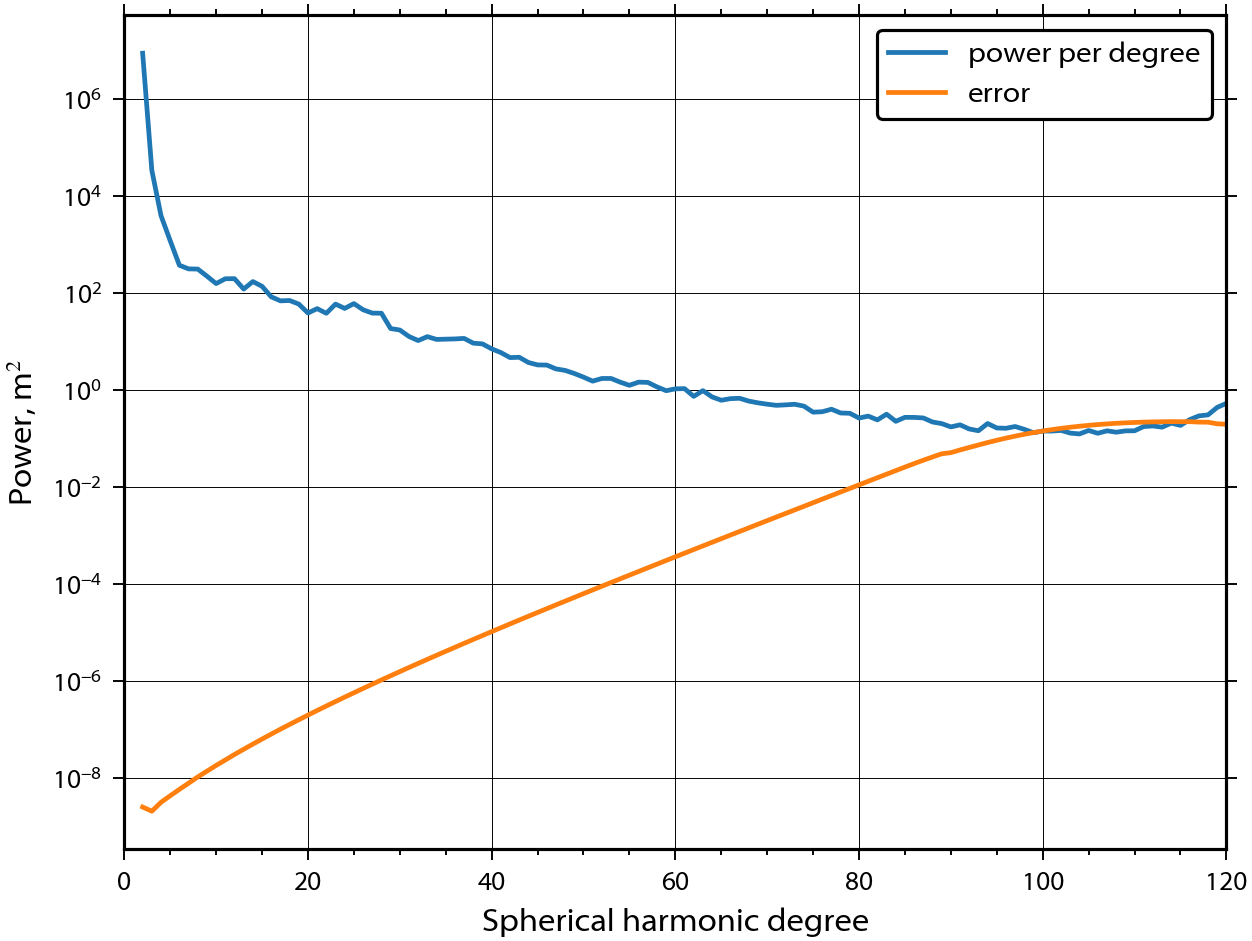

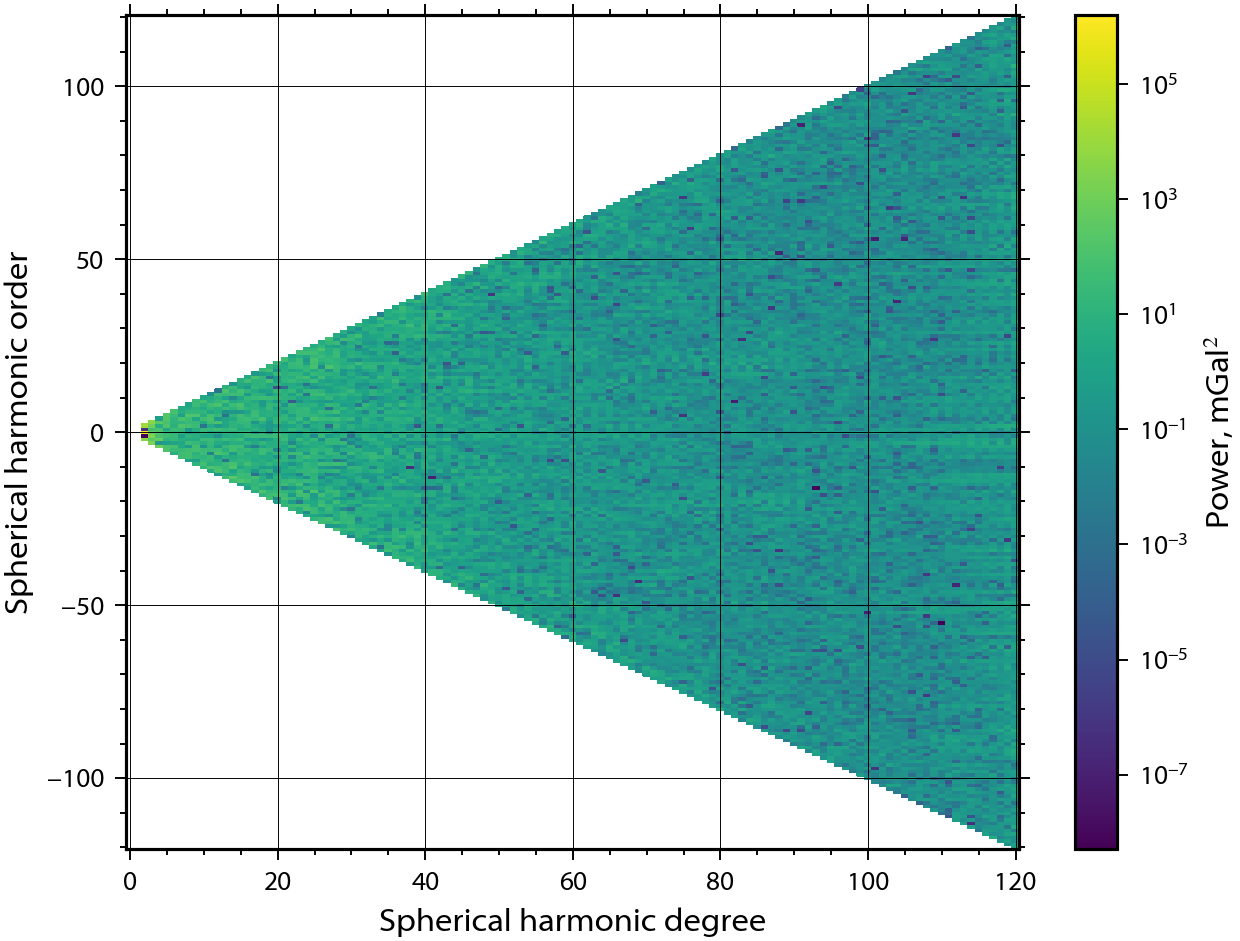

In [6]:
fig1, ax1 = clm.plot_spectrum(function='geoid', show=False)
fig2, ax2 = clm.plot_spectrum2d(function='total', show=False)

If the errors of the gravitational potential are set, `plot_spectrum()` will compute automatically and plot the error spectrum. For `plot_spectrum2d()`, the errors can be plotted by specifying `errors=True`. By default, the power associated with the degree 0 and 1 terms will not be plotted, because the degree 0 term is orders of magnitude larger than the others, and the degree-1 terms are zero when in center-of-mass coordinates.

Next, we use the method `expand()` to calculate grids of the gravitational potential, the three vector components of the gravity field, and the total gravity disturbance. By default, these values are calculated on a sphere whose radius is equal to the reference radius `r0`. By specifying the parameters `a` and `f`, these quantities will instead be calculated on a flattened ellipsoid. In this case, it should be emphasized that the vector components still correspond to the spherical coordinate unit vectors $\hat{r}$, $\hat{\theta}$, and $\hat{\phi}$, and not components that are perpendicular to the reference ellipsoid. By default, the normal gravity is removed from the total gravitational acceleration, yielding the gravity disturbance.

The `expand()` method returns an `SHGravGrid` class instance. This class stores each of the five grids, `rad`, `theta`, `phi`, `total`, and `pot` as `SHGrid` class instances. The four gravity grids can be plotted together using the method `plot()`:

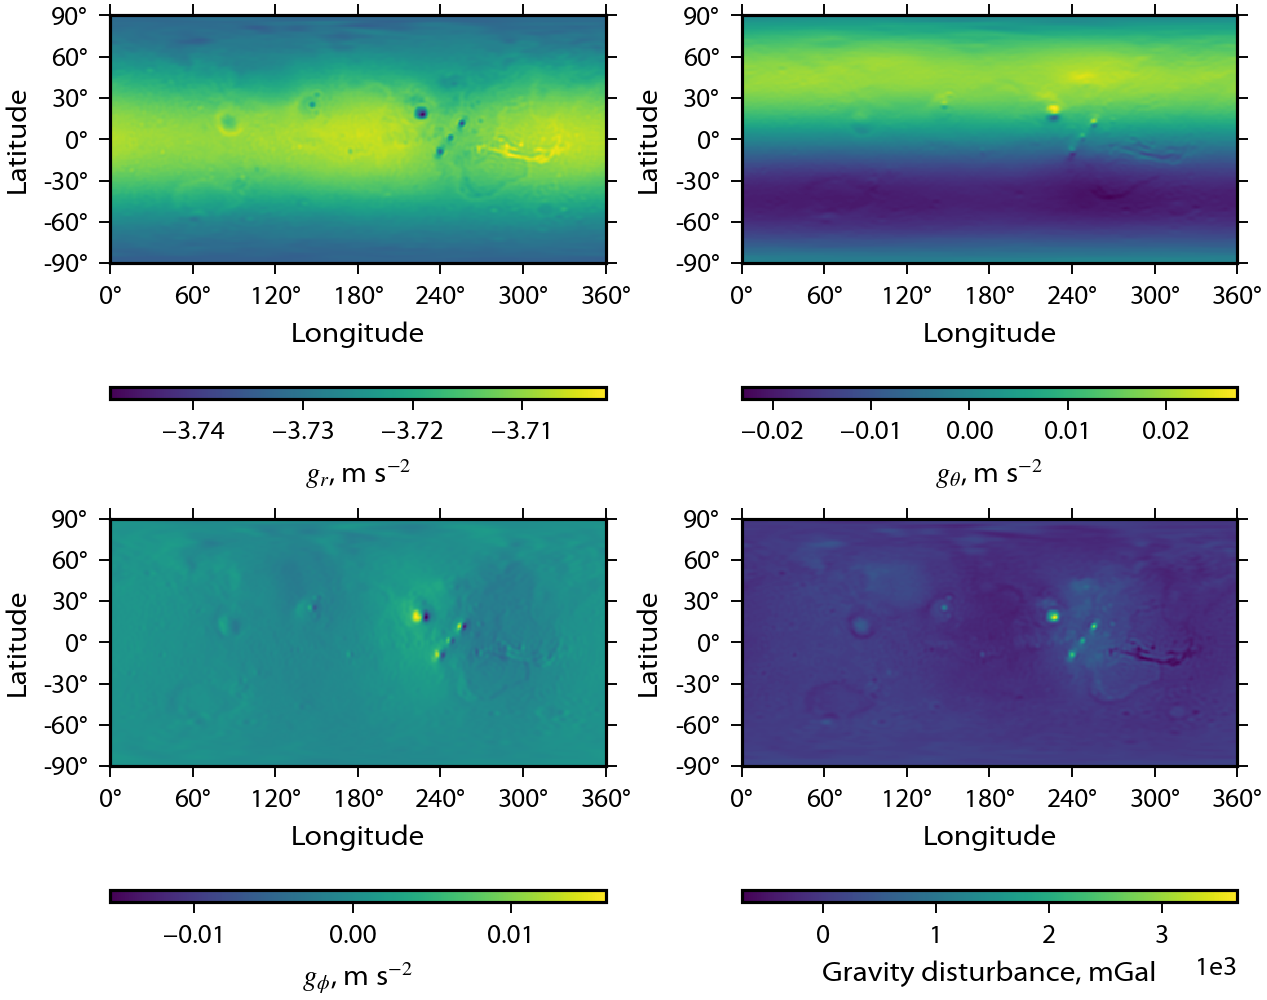

In [7]:
grav = clm.expand(lmax=95, a=a, f=f)
fig2, ax2 = grav.plot(show=False)

Individual maps can be plotted using the corresponding methods `plot_rad()`, `plot_theta()`, `plot_phi()`, `plot_total()`, and `plot_pot()`. Here, we plot the total gravity disturbance, and use the parameters `cmap` and `cmap_limits` to set the minimum and maximum values and color scale, respectively:

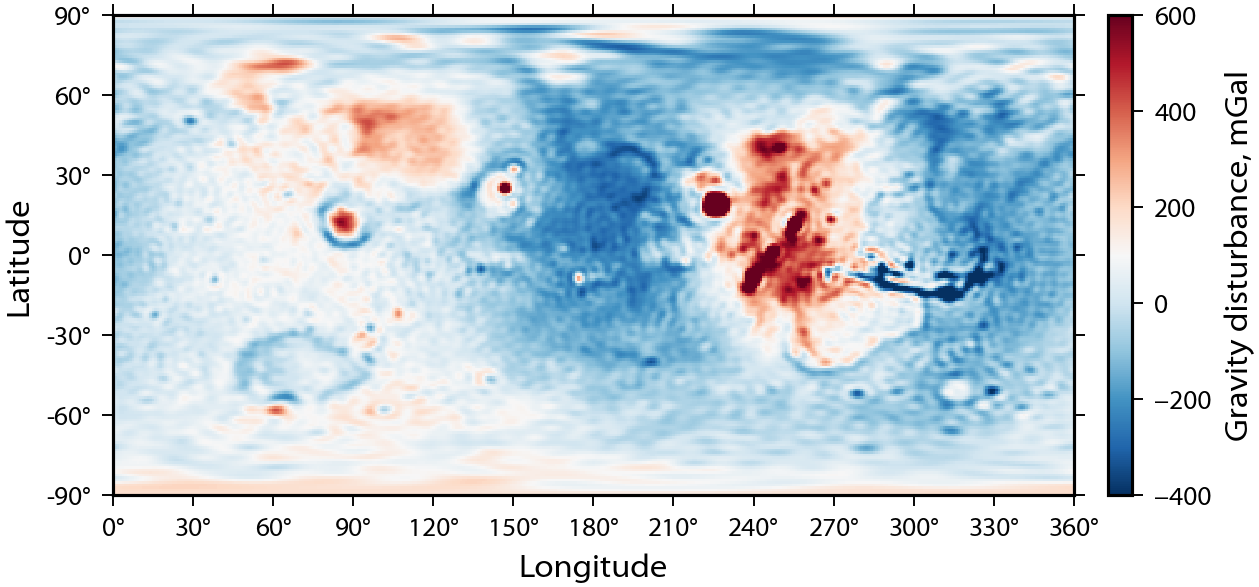

In [8]:
fig3, ax3 = grav.plot_total(cmap='RdBu_r',
                            cmap_limits=[-400, 600],
                            show=False)

Remember, you should **never** use the 'rainbow' and 'jet' colormaps! Colormaps are discussed more in the following notebook.

The geoid is computed using the `geoid()` method. By specifying the reference potential (in m$^2$/s$^2$), the height is calculted with respect to a sphere of reference radius `r0`. This method returns an `SHGeoid` class instance, where the geoid map is stored internally as an `SHGrid` class instance. Here, we compute the geoid on a grid that has a finer resolution than the potential coefficients by specifying the optional variable `lmax`. The reason for doing so is to compare this map directly to a higher resolution map of the shape of the planet later:

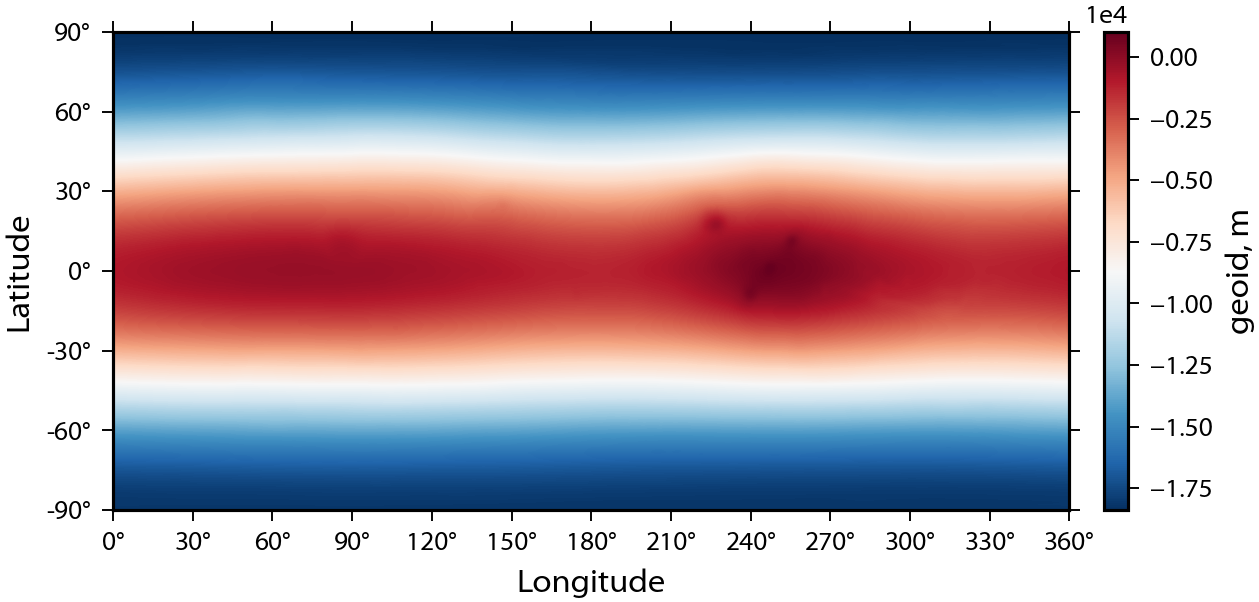

In [9]:
mars_geoid = clm.geoid(u0, lmax=719)
fig4, ax4 = mars_geoid.plot(cmap='RdBu_r', show=False)

In this image, the geoid height largely reflects the rotational flattening of the planet. To calculate the geoid height with respect to a flattened ellipsoid, it is only necessary to specify the optional parameters `a` and `f`:

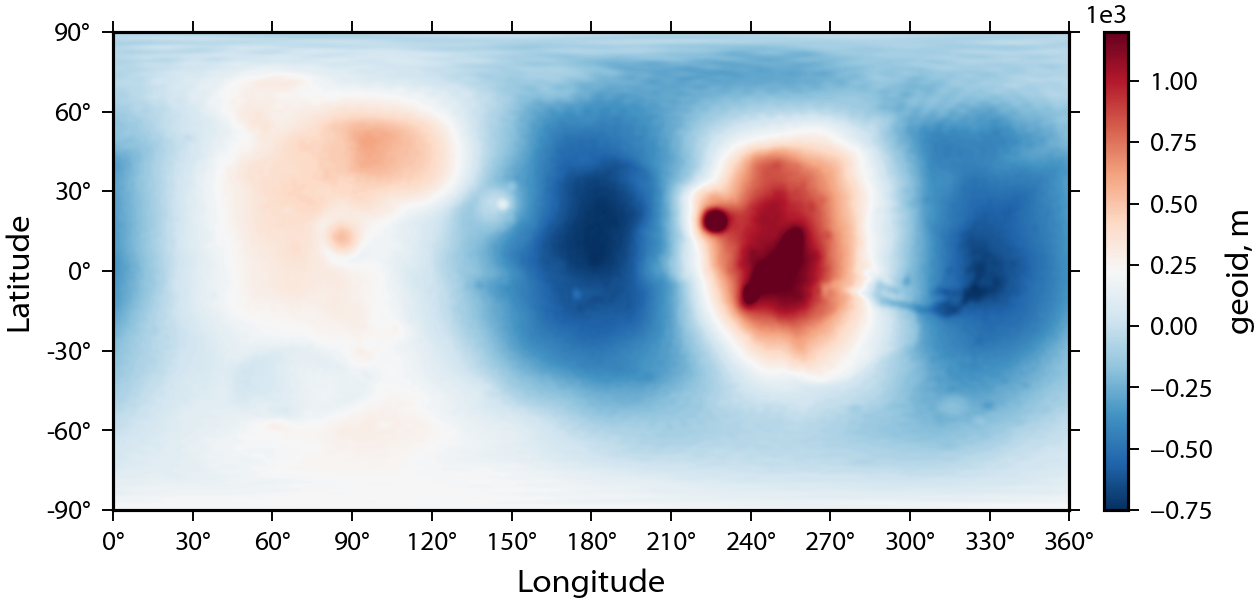

In [10]:
mars_geoid_ellipsoid = clm.geoid(u0, a=a, f=f, lmax=719)
fig5, ax5 = mars_geoid_ellipsoid.plot(cmap='RdBu_r',
                                      cmap_limits=[-750, 1200],
                                      show=False)

With the geoid calculated, we next compute a map of the planet's surface relief with respect to the geoid. First, we read in the spherical harmonic coefficients of the shape of the planet and expand this onto a grid. For this, we make use of the model `MarsTopo719.shape`, which is a truncated version of the 2600 degree and order model of Wieczorek (2015). Then, we subtract the geoid height and the geoid reference radius from the shape to yield a topographic map:

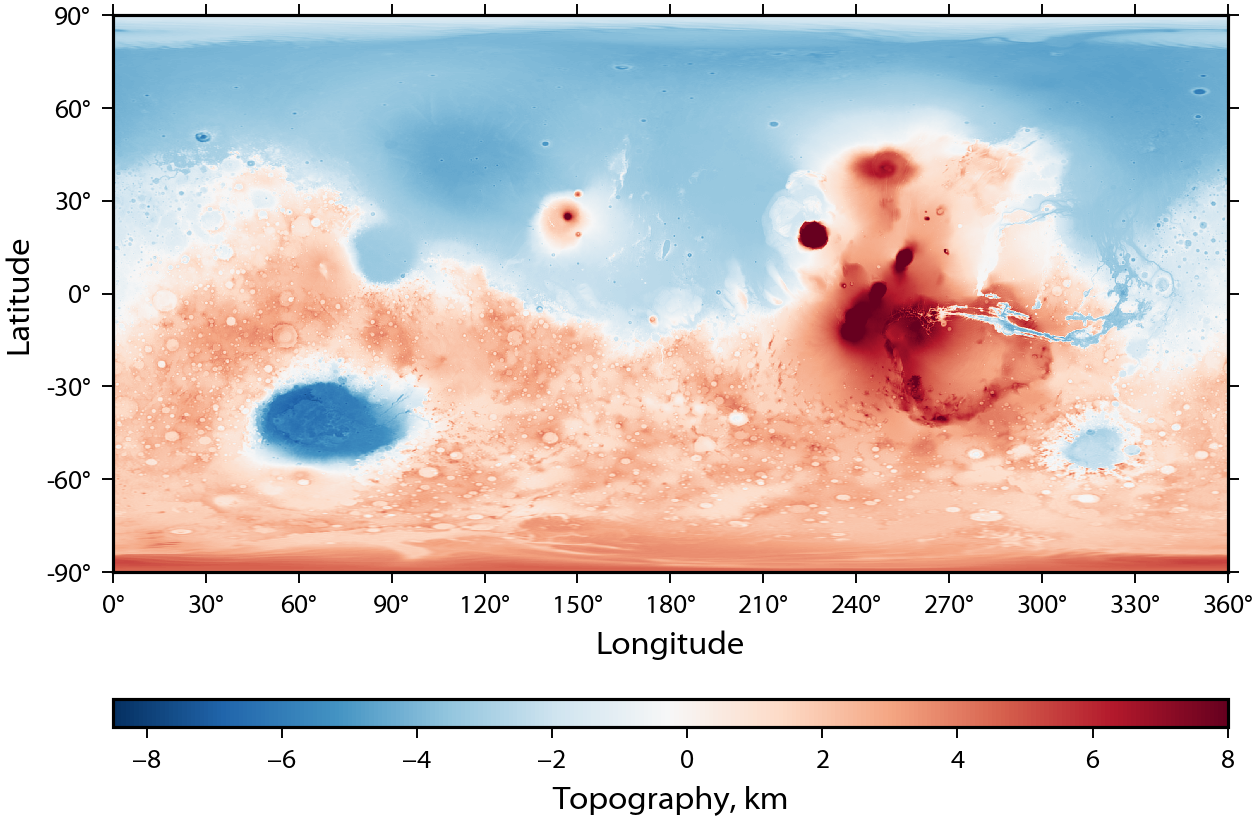

In [11]:
shape = pysh.SHCoeffs.from_file('../ExampleDataFiles/MarsTopo719.shape')
shape_grid = shape.expand(grid='DH2')
topo_grid = (shape_grid - mars_geoid.a - mars_geoid.geoid)/1.e3
fig6, ax6 = topo_grid.plot(colorbar='bottom',
                           cb_label='Topography, km',
                           cmap='RdBu_r',
                           cmap_limits=[-8.5, 8.],
                           show=False)

Next, we remove the gravitational attraction of the surface topography from the free-air gravity to obtain the Bouguer anomaly. Using the `SHGravCoeffs.from_shape()` method, the gravitational attraction corresponding to relief with respect to a spherical interface is obtained. This method uses the finite-amplitude technique described in Wieczorek (2015), and can account for either a constant density contrast across the interface, or a density contrast that varies laterally. The density contrast can be specified either as a scalar, or an `SHGrid` or `SHCoeffs` class instance. For this example, we set the density contrast equal to a constant, specify the GM of the planet, and set the maximum spherical harmonic degree to compute:

In [12]:
bc = pysh.SHGravCoeffs.from_shape(shape,
                                  rho=2800.,
                                  gm=clm.gm,
                                  lmax=120)

Inspection of `bc` shows that the reference radius of the Bouguer correction corresponds to the average radius of the surface relief, which is different from the reference radius of the gravitational potential coefficeints `clm`:

In [13]:
bc.info()

kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 120
GM (m3 / s2) = 42828372854187.75
r0 (m) = 3389500.12207057
Omega (rad / s) = None
errors are set: False
header = None


To reference the coefficients `bc` to a different radius by upward continuation, it is only necessary to use the method `change_ref()` and specify the new reference radius. After doing so, we subtract the Bouguer correction from the free-air gravitational potential coefficients, yielding the Bouguer anomaly:

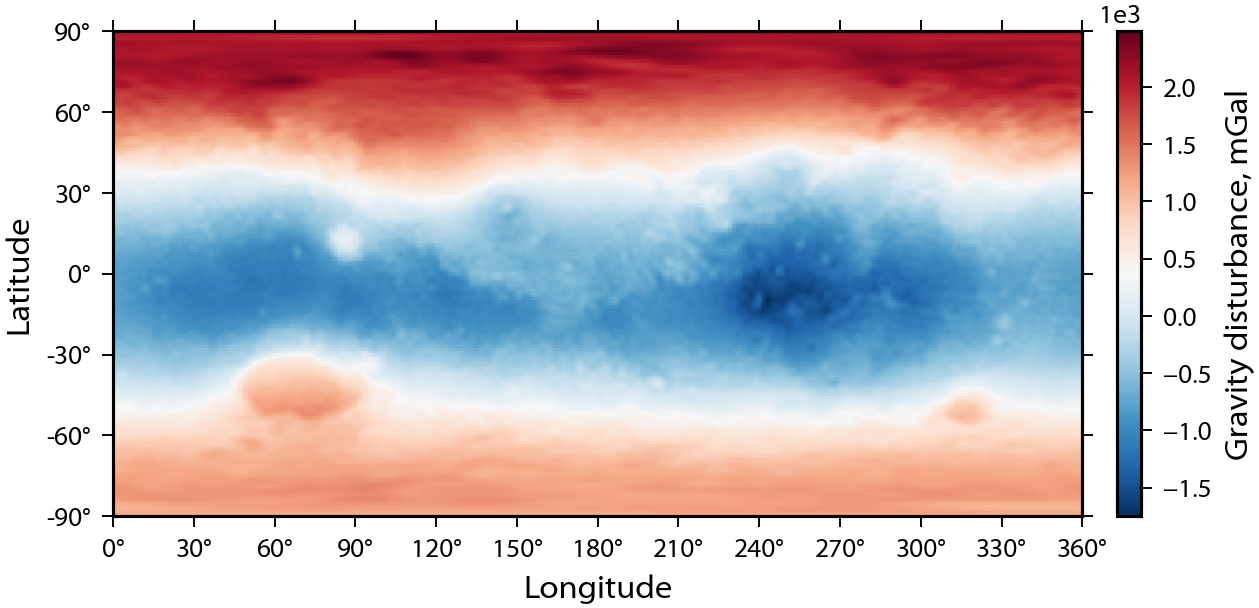

In [14]:
bc = bc.change_ref(r0=clm.r0)
bouguer = clm - bc
bouguer_grid = bouguer.expand(lmax=95, a=a, f=f)
fig7, ax7 = bouguer_grid.plot_total(cmap='RdBu_r', show=False)

It is immediately obvious that the Bouguer anomaly plot has a large component associated with the flattening of the planet: This is simply because the Bouguer correction was computed for relief with respect to a sphere, and not with respect to a flattened ellipsoid.

We next caclulate the gravity "gradient" tensor using the method `tensor()`. By default, this method sets the degree-0 term of the gravitational potential coefficients to zero, but the full tensor can be calculated by specifying `degree0=True`. The `tensor()` method computes all 9 components of the symmetric gravity tensor and returns an `SHGravTensor` class instance. Similar to the `SHGravGrid` and `SHGeoid` classes, each of the 9 components are stored as `SHGrid` class instances with names `vxx`, `vxy`, `vxz`, `vyx`, `vyy`, `vyz`, `vzx`, `vzy`, `vzz`. Here, we use the built-in method `plot_vxx()` to plot the $V_{xx}$ component of the gravity tensor:

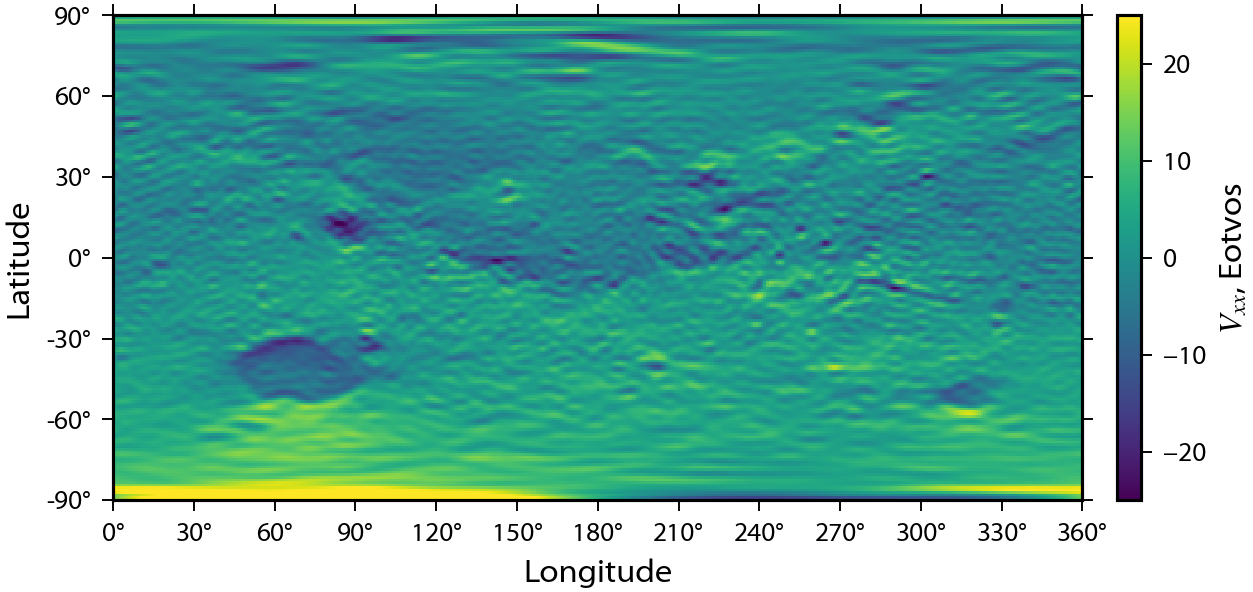

In [15]:
tensor = bouguer.tensor(lmax=95)
fig8, ax8 = tensor.plot_vxx(cmap_limits=[-25, 25], show=False)

The three eigenvalues of the gravity tensor, as well as the three invariants, can be computed with the methods `compute_eig()` and `compute_invar()`. Plotting any of these variables automatically calls these methods, and here we plot the three eigenvalues that are associated with the Bouguer anomaly:

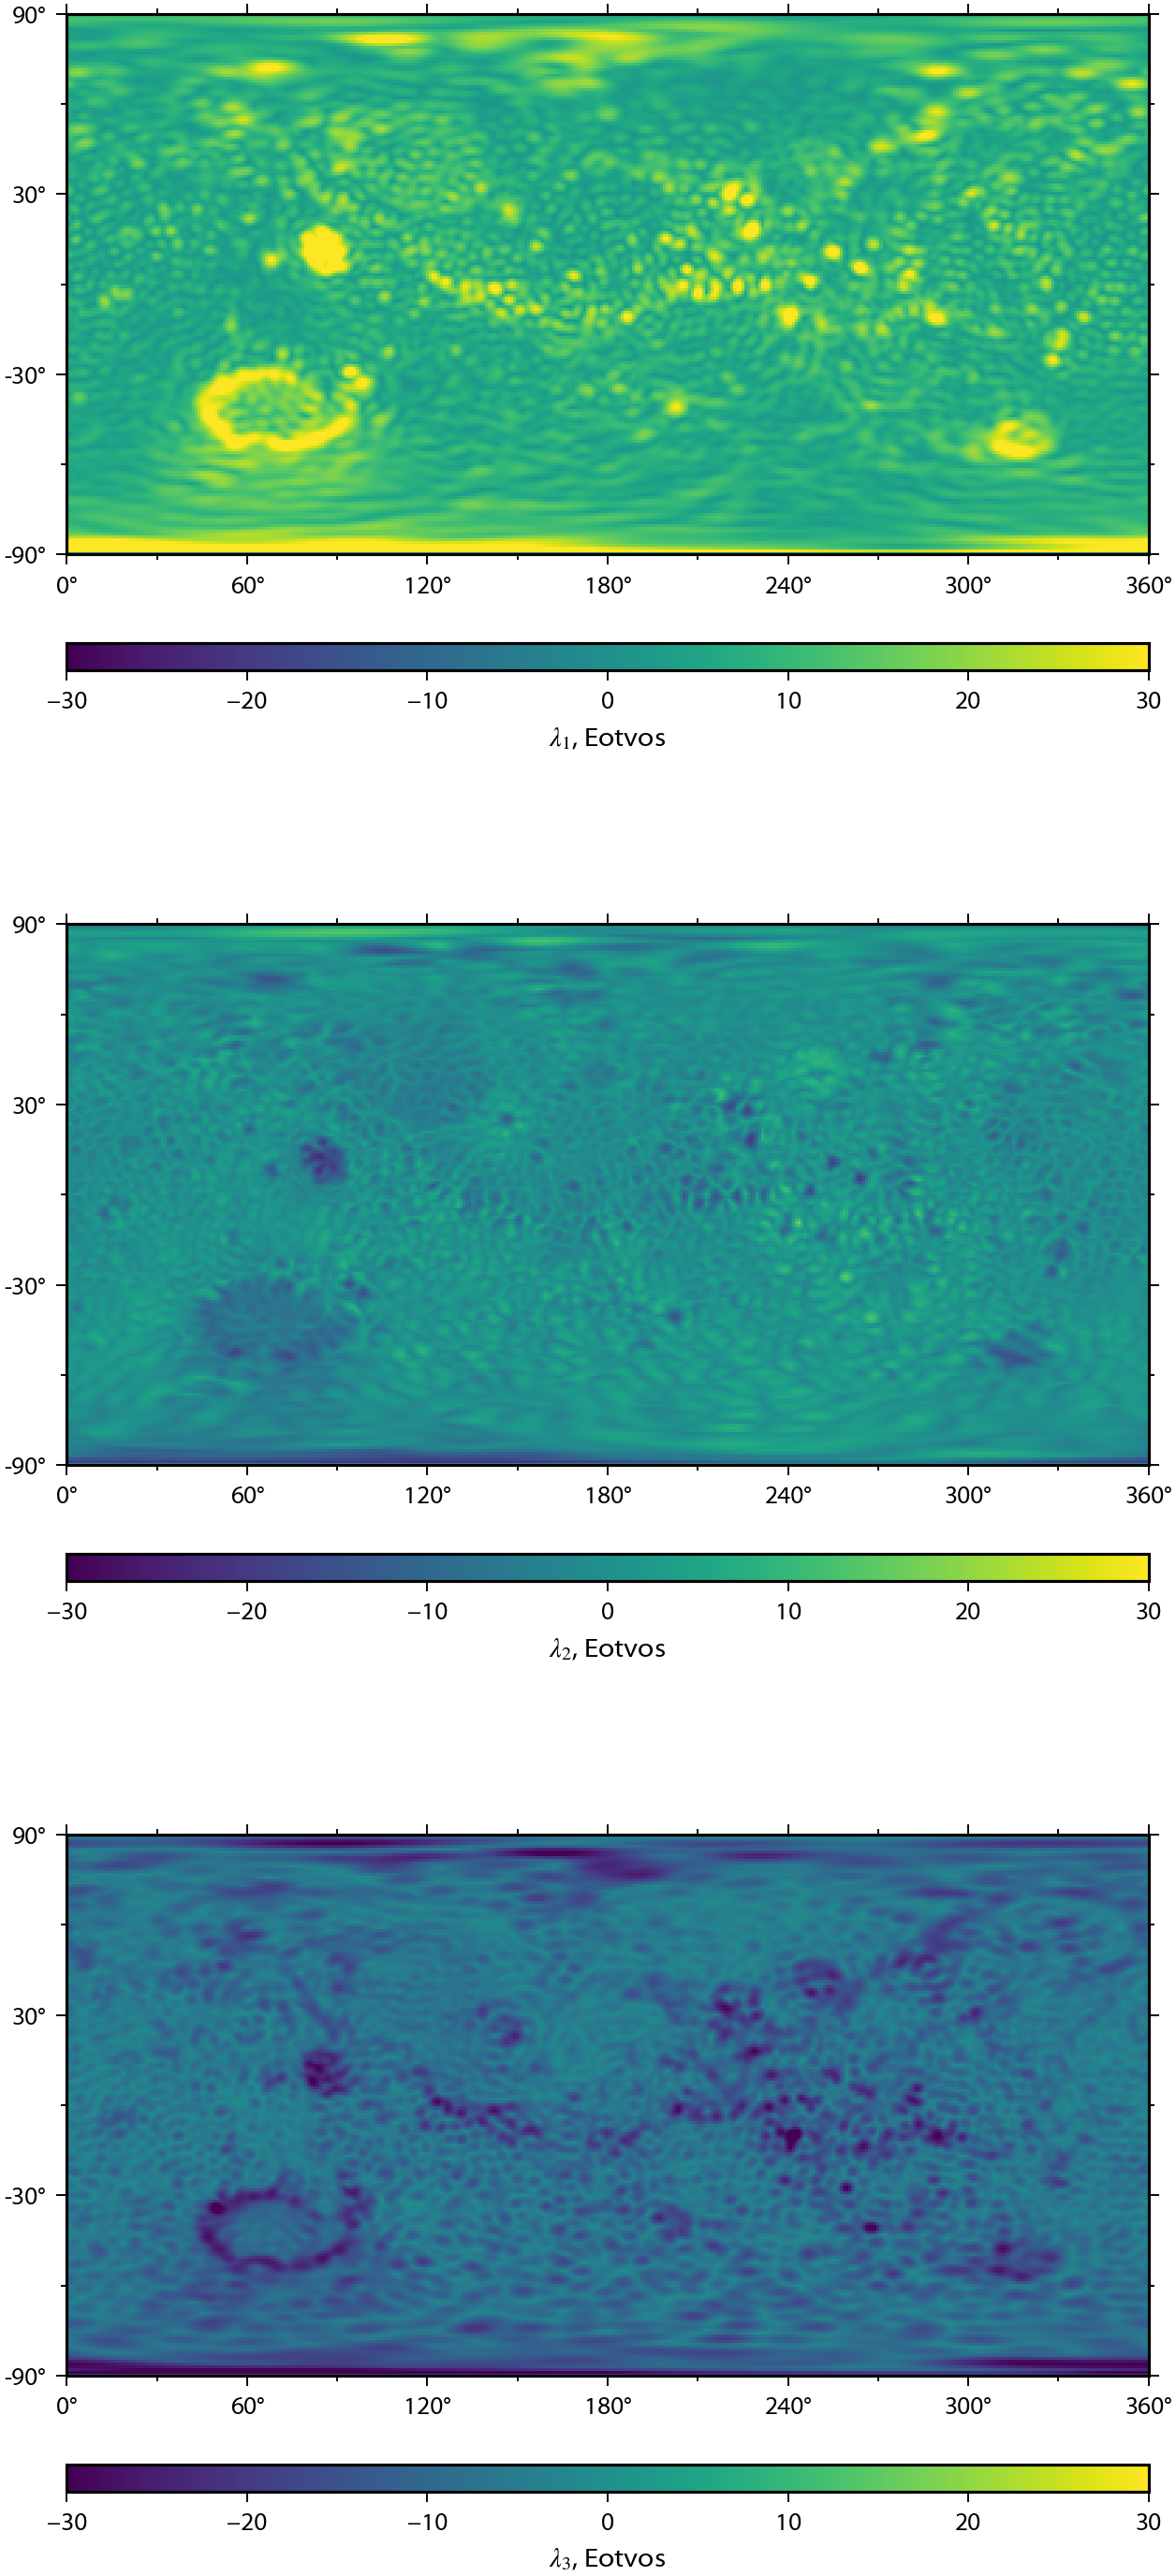

In [16]:
fig9, ax9 = tensor.plot_eigs(cmap_limits=[-30, 30], show=False)

Lastly, the `GravTensor` class allows one to compute the horizontal eigenvalues. In contrast to the eigenvaules calculated above, these are computed using only the horizonal components of the tensor $V_{xx}$, $V_{xy}$, $V_{yx}$, and $V_{yy}$. Here we plot the maximum and minimum horizontal eigenvalues, $\lambda_{h1}$ and $\lambda_{h2}$:

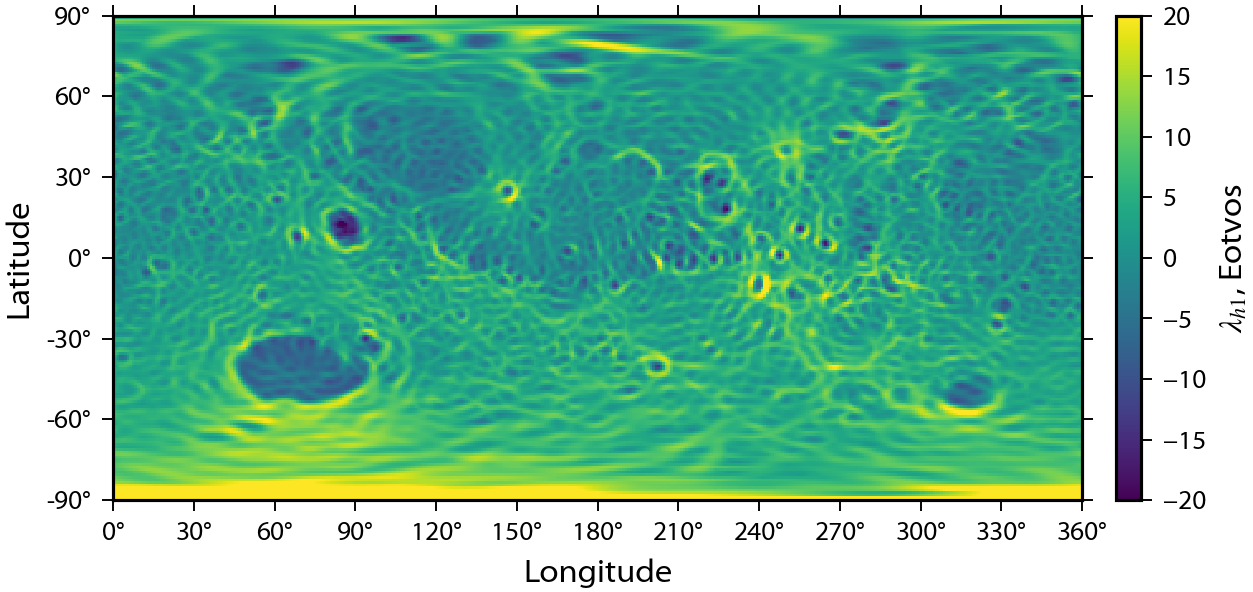

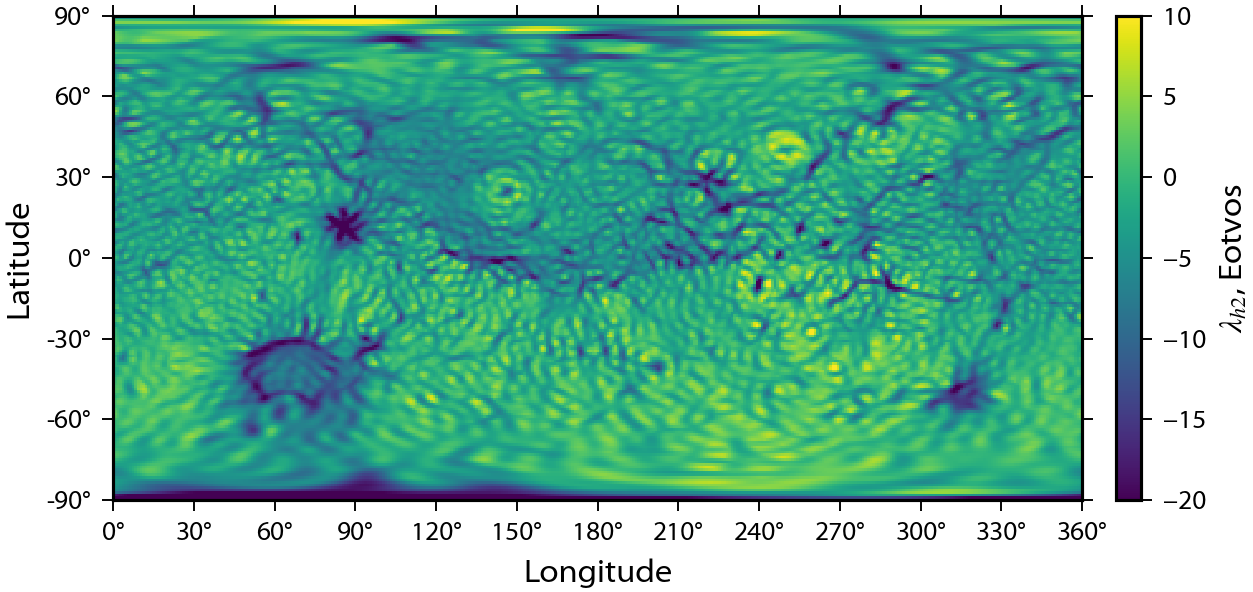

In [17]:
fig10, ax10 = tensor.plot_eigh1(cmap_limits=[-20, 20], show=False)
fig11, ax11 = tensor.plot_eigh2(cmap_limits=[-20, 10], show=False)

## Magnetic Field Classes

The classes for working with magnetic fields are nearly identical to those for use with gravity fields. Magnetic potential coefficients are stored as an `SHMagCoeffs` class instance, and the methods `expand()` and `tensor()` are used to initialize `SHMagGrid` and `SHMagTensor` class instances. By default, the spherical harmonic coefficients of the magnetic potential are assumed to have units of nT.

Unlike the classes for working with gravity coefficients, which use by default $4\pi$ normalized harmonics, for the magnetic field classes, the default is to use Schmidt semi-normalized harmonics. Regardless, in either class, one can store the coefficients using any normalization one chooses: The vast majority of methods return spectra and grids that are independent of the chosen normalization. Another difference with respect to the gravity classes is that it is not necessary to specify the `gm` of the planet, nor the rotation rate `omega`. Lastly, there is no magnetic field class that is analogous to `SHGeoid`. 